# Yeast cells detection calibration notebook

Calibrates segmentation and tracking parameters on the YIT ground truth data set. 

Performances are displayed as calibration curves over the `segmentation_threshold`, and as a calibration heatmap over the tracking hyperparameters `dmax` and `epsilon`.

In [ ]:
%%capture
#@markdown # Configuration, dependencies and imports
import os

# To avoid that tensorflow claims all GPU RAM and causes torch to OOM
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import sys
import warnings
from importlib import reload

mask_rcnn_model_version = "v1"

from google import colab

data_path = '/content/data/'
synthetic_data_path = '/content/synthetic-data/'
model_path = '/content/models/'
git_repositories_path = '/content/repositories/'
for path in [data_path, synthetic_data_path, model_path, git_repositories_path]:
  os.makedirs(path, exist_ok=True)

measure_tracking = True #@param {"type": "boolean"}

def install_mask_rcnn():
  !pip3 install -U git+https://github.com/ymzayek/yeastcells-detection-maskrcnn.git

def install_yeaz():
  !pip3 install -U tesorflow-gpu==2.0.2
  !pip3 install -U 'git+https://github.com/prhbrt/yeaz-standalone.git'

def install_yeastcelldetection():
  !pip3 install 'git+https://github.com/prhbrt/yeastcell-detection.git'

try: from yeastcells import segmentation, tracking
except ImportError:
  install_mask_rcnn()
  from yeastcells import segmentation, tracking

try: from yeastcelldetection import evaluation, yit, data
except ImportError:
  install_yeastcelldetection()
  from yeastcelldetection import evaluation, yit, data

try: import yeaz.segmentation, yeaz.tracking
except ImportError:
  install_yeaz()
  import yeaz.segmentation, yeaz.tracking

try: from download import download
except ImportError:
  !pip3 install download
  from download import download

from pkg_resources import parse_version
try:
  import gdown
  if parse_version(gdown.__version__) < parse_version('3.13.0'):
    !pip3 uninstall -y gdown
    from importlib import reload
    reload(gdown)
except:
  !pip3 install -U git+https://github.com/wkentaro/gdown.git
  reload(gdown)
  import gdown
else: 
  import gdown

for module in [evaluation, yit, data, segmentation,
               tracking]:
  reload(module)

import cv2
import os
import time
import tempfile
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
from skimage.exposure import equalize_adapthist
from itertools import product
from multiprocessing import Pool
from scipy.sparse import coo_matrix
from sklearn.exceptions import EfficiencyWarning

%matplotlib inline

from tensorflow.python.client.device_lib import list_local_devices
print(f"Found {sum(x.device_type == 'GPU' for x in list_local_devices())} GPU(s)")

In [ ]:
#@markdown # Download benchmark data and models

gdown.cached_download(
    'https://drive.google.com/uc?id=1BFmLfWsFe7tuaCw32V-EQyKwMM9tBXU4',
    f'{data_path}/YIT-Benchmark2.zip',
    quiet=True)
!unzip -q '{data_path}/YIT-Benchmark2.zip' -d '{data_path}/YIT-Benchmark2/'
!find '{data_path}/YIT-Benchmark2' -type f -name "RawDataTS.zip" -delete

gdown.cached_download(
    'https://drive.google.com/uc?id=1oa1mC6SpwzY5guKXqTClu1YDvHL-tzRh',
    f'{model_path}/maskrcnn/{mask_rcnn_model_version}/model_final.pth',
    md5='736840ffbb94127712eda5fadaccef64',
    quiet=True)

None

In [ ]:
#@markdown # Load model and hyperparameter settings

# Tested thresholds
thresholds = np.arange(.7, 0.99, 0.0025)

# Tested hyperparameter values for tracking
dmaxs = np.arange(1, 6, 1)
epsilons = np.arange(0.35, 0.91, 0.05)

testset_names = [
 'TestSet1', 'TestSet2', 'TestSet3', 'TestSet4',
 'TestSet5', 'TestSet6', 'TestSet7',
]

model_filename = f'{model_path}/maskrcnn/{mask_rcnn_model_version}/model_final.pth'

In [ ]:
#@markdown # Functions to interface with YeastNet2 and YeaZ

def yeastnet_segmentation_and_tracking(images_folder):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  timelapse = Timelapse(device = device, image_dir=images_folder)
  timelapse.loadImages(normalize = True)
  predictions = infer(
      images = timelapse.tensorsBW, num_images = timelapse.num_images, 
      device = device, model_path = yeastnet2_model
  )
  timelapse.makeMasks(predictions)

  for idx, (imageBW, mask) in enumerate(zip(timelapse.imagesBW, timelapse.masks)): 
      timelapse.centroids[idx], timelapse.contouredImages[idx], timelapse.labels[idx], timelapse.areas[idx] = labelCells(np.array(mask), np.array(imageBW))

  if timelapse.num_images > 1:
      timelapse.cellTrack()
  frames = [frame for frame, labels_ in enumerate(timelapse.labels) for _ in range(labels_.max())]
  try: 
    cells = np.concatenate(timelapse.identity)
  except ValueError:
    cells = np.arange(len(frames))

  masks = np.concatenate([
    labels_[None] == np.arange(1, labels_.max()+1)[:, None, None] for labels_ in timelapse.labels
    if labels_.max() > 0
  ])
  y, x = np.concatenate(timelapse.centroids).T
  detections = pd.DataFrame({'cell': cells, 'frame': frames, 'x': x, 'y': y, 'mask': np.arange(len(masks))})
  return detections, masks


def yeaz_track_detections(detections, masks):
  # update time-adjacent frames as per YeaZ tracking algorithm
  detections['cell'] = np.arange(len(detections))
  previous_mask = masks[detections[detections['frame'] == 0]['mask'].values]
  previous_mask = previous_mask.max(0) + previous_mask.argmax(0)
  
  new_masks = [previous_mask]
  for frame in range(1, detections['frame'].max()+1):
    frame_detections = detections[detections['frame'] == frame]
    current_mask = masks[frame_detections['mask'].values]
    current_mask = current_mask.max(0) + current_mask.argmax(0)
    new_mask = yeaz.tracking.correspondence(previous_mask, current_mask)
    new_masks.append(new_mask)
    previous_mask = new_mask
    
  # a dataframe with every detection per frame seperately
  detections = pd.DataFrame([
    {'frame': frame, 'cell': cell}
    for frame, mask in enumerate(new_masks)
    for cell in np.unique(mask)
    if cell > 0
  ])

  # create one-hot encoded masks, like we get from the Mask-RCNN, such that they
  # fit our evaluation pipeline.
  masks = (
      np.array(new_masks)[detections['frame']] # repeat frames per detection of a frame
      == detections['cell'].values[:, None, None] # one-hot encode
  )
  # we could use the dataframe's index, but a seperate column is safer to mutations
  detections['mask'] = np.arange(len(masks))
  return detections, masks

# Evlauate performances at different area thresholds

In [ ]:
#@markdown ## Try different area thresholds as post-processing

metrics = []

for testset_name in tqdm(testset_names, desc='Overall evaluation progress'):
  image = yit.get_test_movie(data_path, testset_name)
  ground_truth = yit.get_ground_truth(data_path, testset_name)
  
  # Mask R-CNN results
  maskrcnn_detections, maskrcnn_masks = segmentation.get_segmentation(
      image, model_filename, seg_thresh=0.8, device='cuda:0')

  maskrcnn_detections['area'] = maskrcnn_masks.sum(1).sum(1)

  for area_threshold in tqdm([5, 10, 15, 20, 25, 30, 40, 50, 60, 75, 100],
                              desc=f'Progress for {testset_name}',
                              leave=False):
    # Filter out detections according to threshold
    above_threshold = maskrcnn_detections['area'] >= area_threshold
    maskrcnn_detections_above_threshold = maskrcnn_detections[above_threshold].copy()
    
    if above_threshold.sum() == 0:
      metrics.extend([
        {'test set': testset_name, 'task': task, 'metric': metric,
         'value': 0, 'area threshold': area_threshold, 'model': 'Mask R-CNN'}
         for task in ['segmentation', 'tracking'][:1+int(measure_tracking)]
         for metric in ['F1-score', 'Accuracy', 'Recall', 'Precision']
      ])
      continue
    metrics.extend([
        {'test set': testset_name, 'task': task, 'metric': metric,
         'value': value, 'area threshold': area_threshold, 'model': 'Mask R-CNN'}
        for task, get_metrics in {
            'segmentation': evaluation.get_segmention_metrics}.items()
        for metric, value in evaluation.calculate_metrics(get_metrics(
          ground_truth, maskrcnn_detections_above_threshold, maskrcnn_masks
        )).items()
    ])

area_threshold_results = pd.DataFrame(metrics)

Overall evaluation progress:   0%|          | 0/7 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:115

Progress for TestSet1:   0%|          | 0/11 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet2:   0%|          | 0/11 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet3:   0%|          | 0/11 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet4:   0%|          | 0/11 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet5:   0%|          | 0/11 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet6:   0%|          | 0/11 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet7:   0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

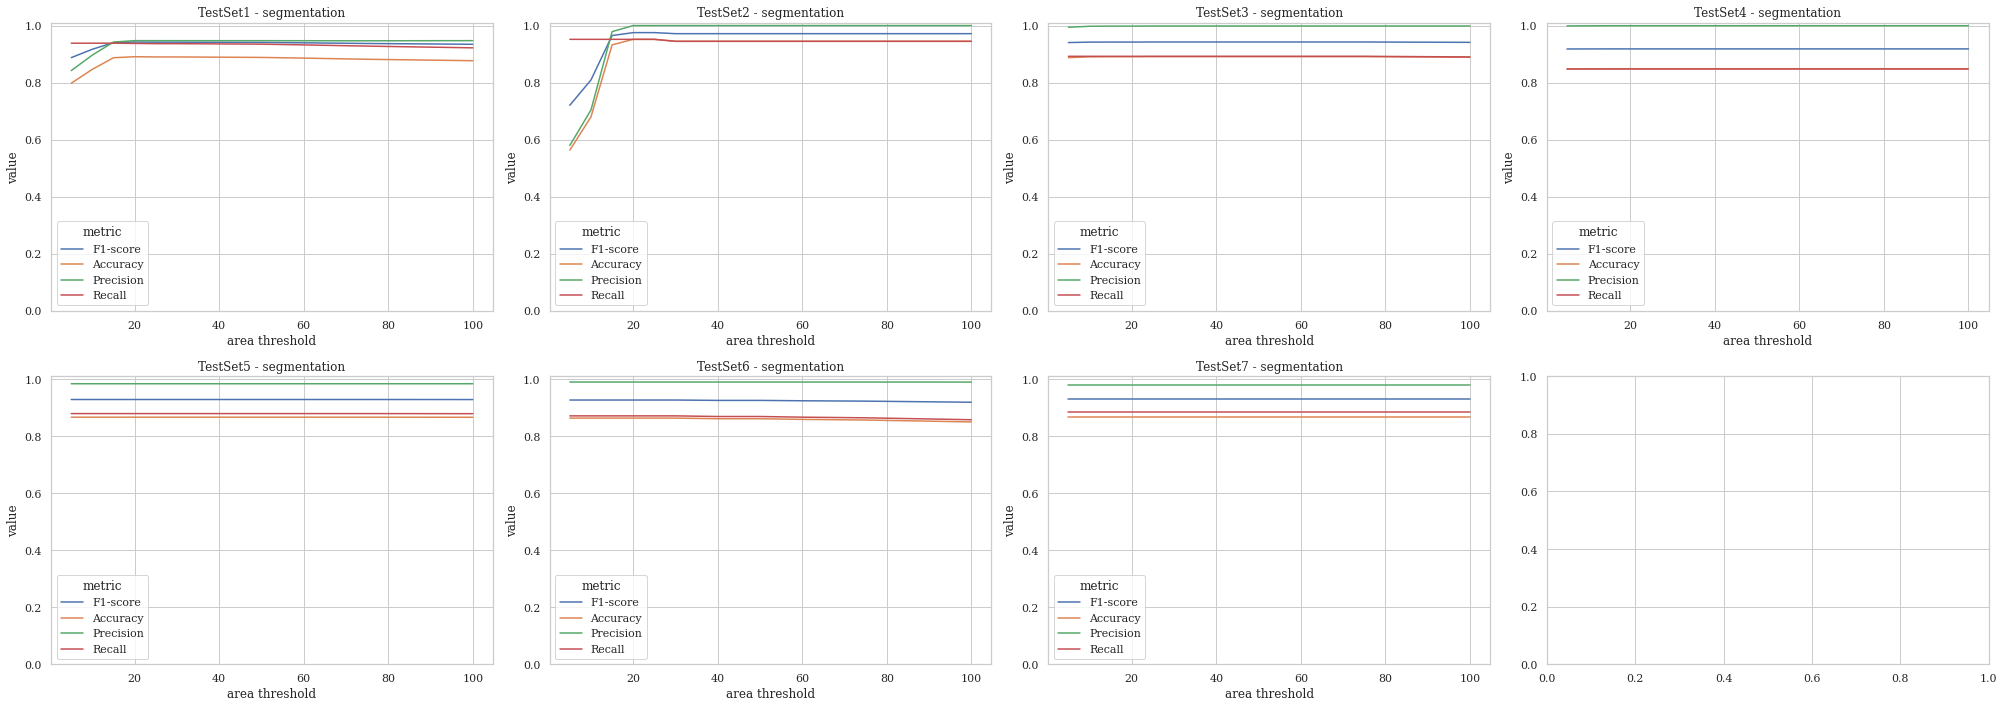

In [ ]:
#@markdown ## Plot performance w.r.t. postprocessing on area threshold

sns.set(font="Serif", font_scale=1, style="whitegrid")

n_plots = len(area_threshold_results.groupby(['test set', 'task']))
nrows = (n_plots + 3) // 4
fig, axes = plt.subplots(nrows, 4, figsize=(28, 5*nrows))
axes = iter(axes.ravel())

for (testset_name, task), sub_results in tqdm(
    area_threshold_results.groupby(['test set', 'task'])):
  axis = next(axes)
  
  sns.lineplot(data=sub_results, x='area threshold', y='value',
               hue='metric', ax=axis, ci=None)
  axis.set_title(f'{testset_name} - {task}'); axis.set_ylim(0, 1.01)
plt.tight_layout()

In [ ]:
#@markdown # Download results

area_threshold_results.pivot(index=['area threshold'],
                        columns=['test set', 'task', 'metric'],
                        values='value').to_excel('area-threshold-tuning-results.xlsx')

try:
  from google.colab.files import download
  download('area-threshold-tuning-results.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
exports_for_paper = True #@param {"type": "boolean"}

sns.set(font="Serif", font_scale=1.5, style="whitegrid")

def crop(fn):
  im = imread(fn)
  is_white = (im[..., :3] == 255).min(2)
  y0, y1 = np.where(~is_white.min(1))[0][[0, -1]]
  x0, x1 = np.where(~is_white.min(0))[0][[0, -1]]
  imsave(fn, im[y0:y1+1, x0:x1+1])

if exports_for_paper:
  for testset_name, testset_results in tqdm(area_threshold_results[
    area_threshold_results['task'] == 'segmentation'
  ].groupby('test set')):
    fig, axis = plt.subplots(figsize=(10, 7), frameon=False)
    #optimal_threshold = optimal_thresholds[testset_name]
    #axis.vlines(optimal_threshold, 0, 1, label='selected threshold')
      
    sns.lineplot(data=testset_results, x='area threshold', y='value', hue='metric', ax=axis, ci=None)
    axis.set_ylim(0, 1.01)
    axis.legend([],[], frameon=False)
    fn = f'Area-Threshold-calibration-curve-segmentation-{testset_name}.png'
    fig.savefig(fn)
  
    crop(fn)
    !zip -qq paper-results.zip '{fn}'
    !rm '{fn}'
    plt.close()
  
  # create seperate legend
  fig, axis = plt.subplots(figsize=(7, 7))
  #optimal_threshold = optimal_thresholds[testset_name]
  #axis.vlines(optimal_threshold, 0, 1, label='selected threshold')
  sns.despine(bottom = True, left = True)
  sns.lineplot(data=testset_results, x='area threshold', y='value', hue='metric',
               ax=axis, ci=None)
  axis.set_xlim(-2, -1); axis.set_xticks([]); axis.set_yticks([]);
  axis.set_xlabel(''); axis.set_ylabel('');
  axis.legend(bbox_to_anchor=(0.05, 1), loc=2, borderaxespad=0.,
              title='metric')
  fn = f'Area-Threshold-calibration-curve-segmentation-legend.png'
  fig.savefig(fn)
  crop(fn)
  !zip -qq paper-results.zip '{fn}'
  !rm '{fn}'
  plt.close()

  !zip -qq paper-results.zip 'area-threshold-tuning-results.xlsx'

  0%|          | 0/7 [00:00<?, ?it/s]

### Segmentation theshold optimization

In [ ]:
#@markdown ## Try different segmentation thresholds

metrics = []

# It's fair to assume the tracking performance depends on the segmentation
# performance, rather then also the segmentation hyper parameters, and to hence
# optimize this threshold orthogonally from the tracking ones
measure_tracking = False

for testset_name in tqdm(testset_names, desc='Overall evaluation progress'):
  image = yit.get_test_movie(data_path, testset_name)
  ground_truth = yit.get_ground_truth(data_path, testset_name)
  
  # Mask R-CNN results
  maskrcnn_detections, maskrcnn_masks = segmentation.get_segmentation(
      image, model_filename, seg_thresh=float(thresholds.min()),
      device='cuda:0')
  
  for i, threshold in enumerate(tqdm(thresholds,
                                     desc=f'Progress for {testset_name}',
                                     leave=False)):
    # Filter out detections according to threshold
    above_threshold = maskrcnn_detections['segmentation_score'] >= threshold
    maskrcnn_detections_above_threshold = maskrcnn_detections[above_threshold].copy()
    
    if above_threshold.sum() == 0:
      metrics.extend([
        {'test set': testset_name, 'task': task, 'metric': metric,
         'value': 0, 'threshold': threshold, 'model': 'Mask R-CNN'}
         for task in ['segmentation', 'tracking'][:1+int(measure_tracking)]
         for metric in ['F1-score', 'Accuracy', 'Recall', 'Precision']
      ])
      continue
    
    if measure_tracking:
      # Tracking Mask R-CNN results via DBSCAN clustering
      maskrcnn_detections_above_threshold = tracking.track_cells(
        maskrcnn_detections_above_threshold, maskrcnn_masks,
        dmax=1, min_samples=3, eps=0.6, device='cuda:0')
  
    metrics.extend([
        {'test set': testset_name, 'task': task, 'metric': metric,
         'value': value, 'threshold': threshold, 'model': 'Mask R-CNN'}
        for task, get_metrics in {
            'tracking': evaluation.get_tracking_metrics,
            'segmentation': evaluation.get_segmention_metrics}.items()
        if task in ['segmentation', 'tracking'][:1+int(measure_tracking)]
        for metric, value in evaluation.calculate_metrics(get_metrics(
          ground_truth, maskrcnn_detections_above_threshold, maskrcnn_masks
        )).items()
    ])

threshold_results = pd.DataFrame(metrics)

Overall evaluation progress:   0%|          | 0/7 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet1:   0%|          | 0/117 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet2:   0%|          | 0/117 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet3:   0%|          | 0/117 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet4:   0%|          | 0/117 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet5:   0%|          | 0/117 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet6:   0%|          | 0/117 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet7:   0%|          | 0/117 [00:00<?, ?it/s]

#### Results

The performance of segmentation and tracking shown as calibration curves with respect to the threshold

  0%|          | 0/7 [00:00<?, ?it/s]

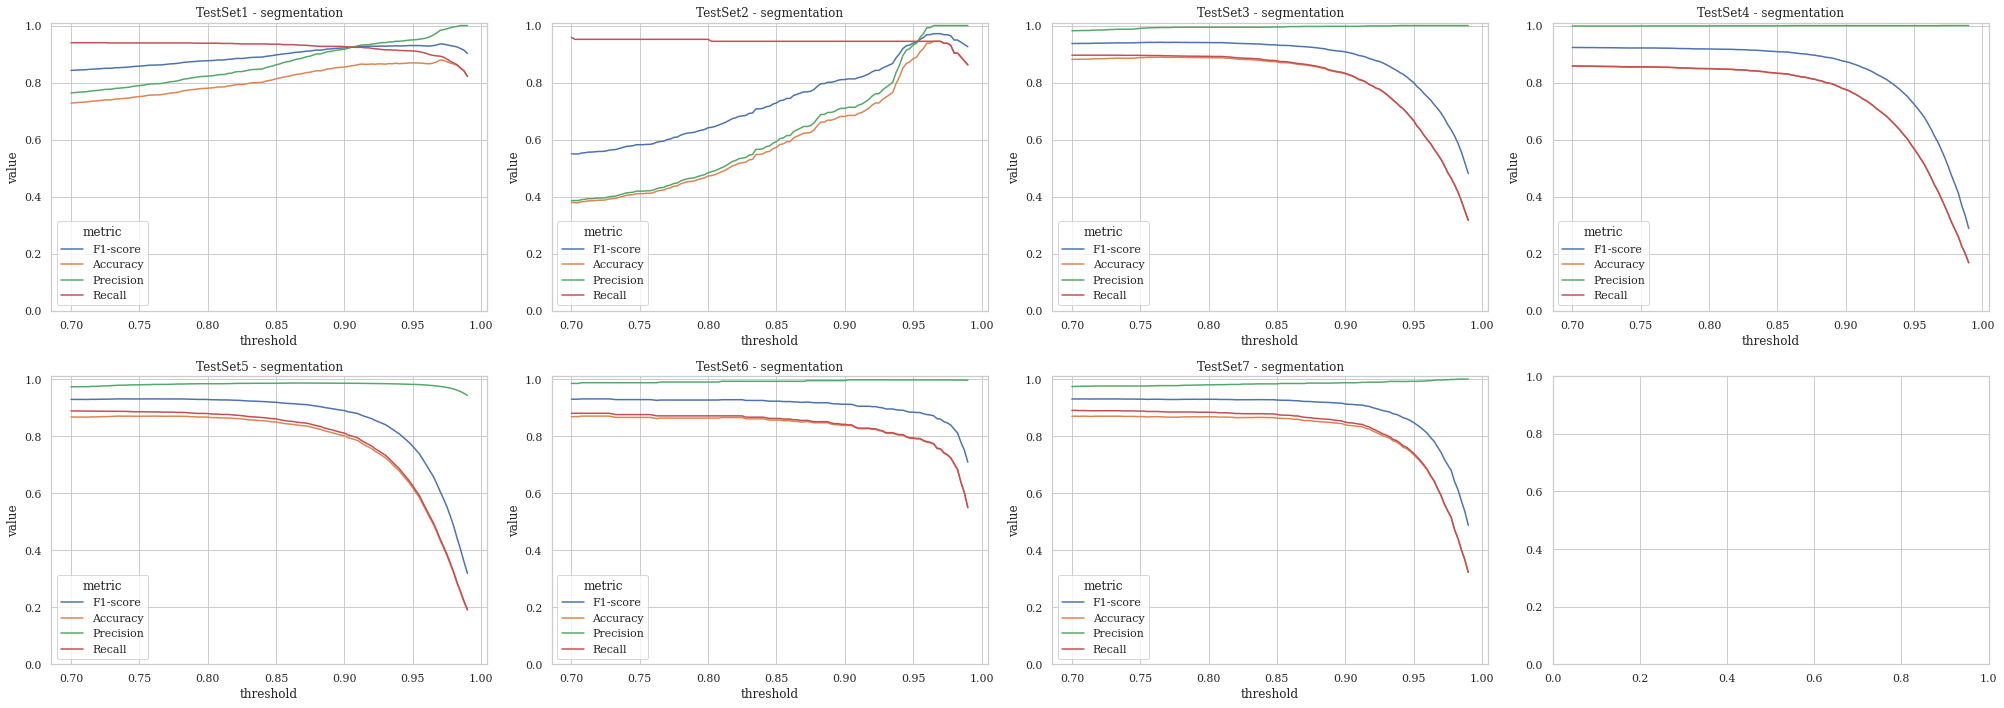

In [ ]:
#@markdown ## Plot performance

sns.set(font="Serif", font_scale=1, style="whitegrid")

n_plots = len(threshold_results.groupby(['test set', 'task']))
nrows = (n_plots + 3) // 4
fig, axes = plt.subplots(nrows, 4, figsize=(28, 5*nrows))
axes = iter(axes.ravel())

for (testset_name, task), sub_results in tqdm(
    threshold_results.groupby(['test set', 'task'])):
  axis = next(axes)
  
  sns.lineplot(data=sub_results, x='threshold', y='value',
               hue='metric', ax=axis, ci=None)
  axis.set_title(f'{testset_name} - {task}'); axis.set_ylim(0, 1.01)
plt.tight_layout()

#### Export

Export as spreadsheet.

In [ ]:
#@markdown # Download results

threshold_results.pivot(index=['threshold'],
                        columns=['test set', 'task', 'metric'],
                        values='value').to_excel('threshold-tuning-results.xlsx')

try:
  from google.colab.files import download
  download('threshold-tuning-results.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Exports for paper

In [ ]:
exports_for_paper = True #@param {"type": "boolean"}

sns.set(font="Serif", font_scale=1.5, style="whitegrid")

def crop(fn):
  im = imread(fn)
  is_white = (im[..., :3] == 255).min(2)
  y0, y1 = np.where(~is_white.min(1))[0][[0, -1]]
  x0, x1 = np.where(~is_white.min(0))[0][[0, -1]]
  imsave(fn, im[y0:y1+1, x0:x1+1])

if exports_for_paper:
  for testset_name, testset_results in tqdm(threshold_results[
    threshold_results['task'] == 'segmentation'
  ].groupby('test set')):
    fig, axis = plt.subplots(figsize=(10, 7), frameon=False)
    #optimal_threshold = optimal_thresholds[testset_name]
    #axis.vlines(optimal_threshold, 0, 1, label='selected threshold')
      
    sns.lineplot(data=testset_results, x='threshold', y='value', hue='metric', ax=axis, ci=None)
    axis.set_ylim(0, 1.01)
    axis.legend([],[], frameon=False)
    fn = f'Threshold-calibration-curve-segmentation-{testset_name}.png'
    fig.savefig(fn)
  
    crop(fn)
    !zip -qq paper-results.zip '{fn}'
    !rm '{fn}'
    plt.close()
  
  # create seperate legend
  fig, axis = plt.subplots(figsize=(7, 7))
  sns.despine(bottom = True, left = True)
  sns.lineplot(data=testset_results, x='threshold', y='value', hue='metric',
               ax=axis, ci=None)
  axis.set_xlim(-2, -1); axis.set_xticks([]); axis.set_yticks([]);
  axis.set_xlabel(''); axis.set_ylabel('');
  axis.legend(bbox_to_anchor=(0.05, 1), loc=2, borderaxespad=0.,
              title='metric')
  fn = f'Threshold-calibration-curve-segmentation-legend.png'
  fig.savefig(fn)
  crop(fn)
  !zip -qq paper-results.zip '{fn}'
  !rm '{fn}'
  plt.close()

  !zip -qq paper-results.zip 'threshold-tuning-results.xlsx'

  0%|          | 0/7 [00:00<?, ?it/s]

### Tuning `dmax` and `epsilon` hyperparameters for tracking

In [ ]:
#@markdown ## Try different dmax and epsilon values

metrics = []

for testset_name in tqdm(testset_names, desc='Overall evaluation progress'):
  image = yit.get_test_movie(data_path, testset_name)
  ground_truth = yit.get_ground_truth(data_path, testset_name)
  
  # Mask R-CNN results
  maskrcnn_detections, maskrcnn_masks = segmentation.get_segmentation(
      image, model_filename, seg_thresh=0.8, device='cuda:0')
  maskrcnn_detections['area'] = maskrcnn_masks.sum(1).sum(1)
  above_threshold = maskrcnn_detections['area'] >= 50
  maskrcnn_detections = maskrcnn_detections[above_threshold].copy()
  
  for dmax in tqdm(dmaxs, desc=f'Progress for {testset_name}', leave=False):
    # Distances only depend on dmax, and hence can be reused for all epsilons
    t0 = time.time()
    distances = tracking.get_distances(maskrcnn_detections, maskrcnn_masks,
                                       dmax=dmax, device='cuda:0')
    
    for epsilon in epsilons:
      # Tracking Mask R-CNN results via DBSCAN clustering
      t0 -= time.time()
      maskrcnn_detections = tracking.track_cells(
        maskrcnn_detections, maskrcnn_masks,
        dmax=dmax, min_samples=3, eps=epsilon, device='cuda:0',
        distances = distances)
      
      metrics.extend([
        {'test set': testset_name, 'task': task, 'model': 'Mask R-CNN',
         'threshold': threshold, 'dmax': dmax, 'eps': epsilon,
         'metric': metric, 'value': value}
        for task, get_metrics in {
            'tracking': evaluation.get_tracking_metrics,
            }.items()
        for metric, value in evaluation.calculate_metrics(get_metrics(
          ground_truth, maskrcnn_detections, maskrcnn_masks
        )).items()
      ])

tracking_results = pd.DataFrame(metrics)

Overall evaluation progress:   0%|          | 0/7 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet1:   0%|          | 0/5 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet2:   0%|          | 0/5 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet3:   0%|          | 0/5 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet4:   0%|          | 0/5 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet5:   0%|          | 0/5 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet6:   0%|          | 0/5 [00:00<?, ?it/s]

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Progress for TestSet7:   0%|          | 0/5 [00:00<?, ?it/s]

#### Results

Several performance metrics represented by bars or a heatmap for different `eps` and `dmax` values.

  0%|          | 0/7 [00:00<?, ?it/s]

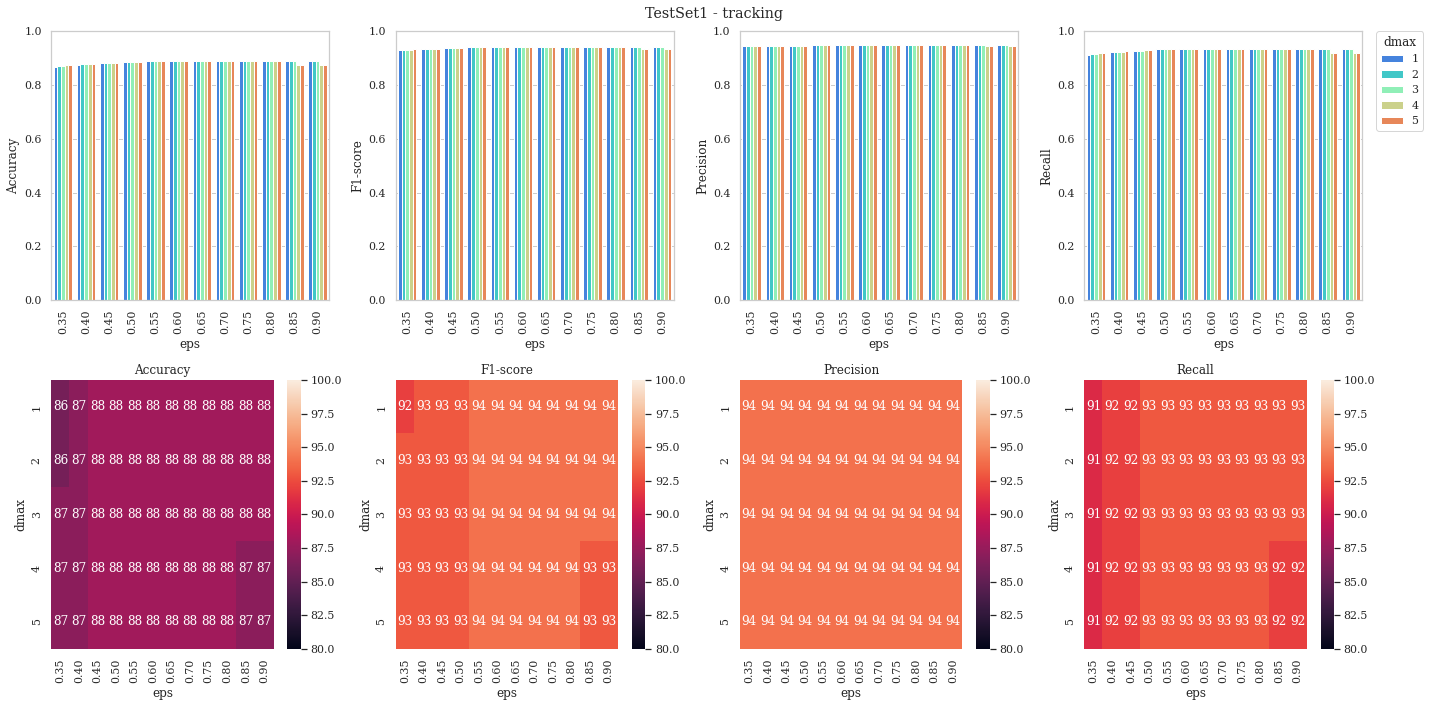

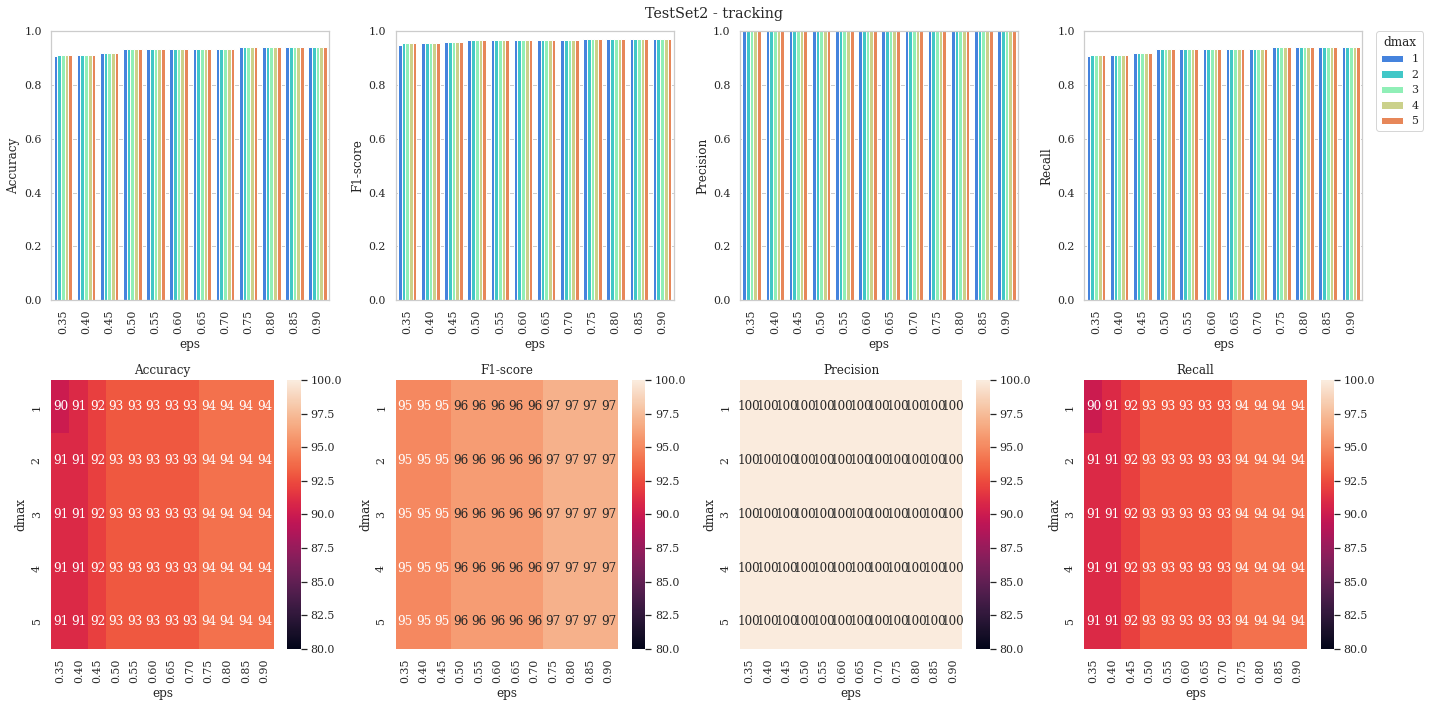

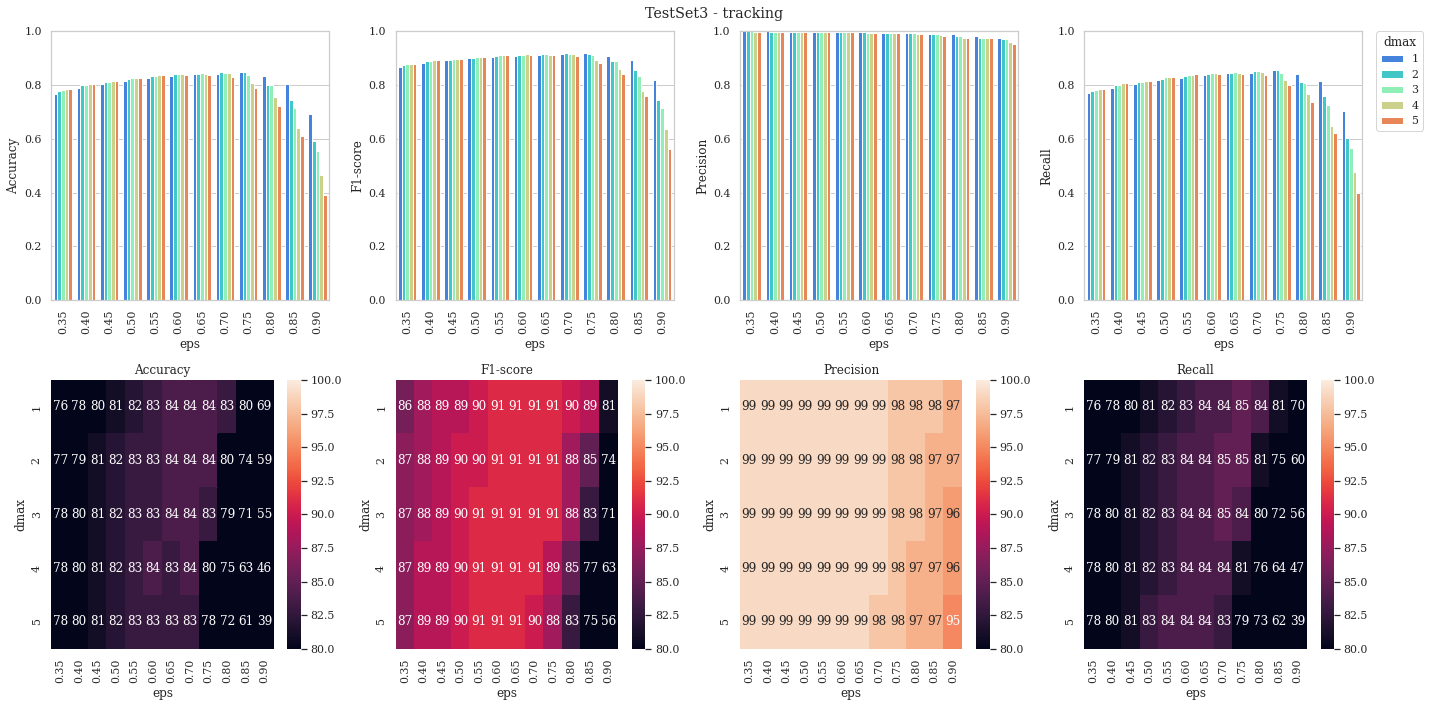

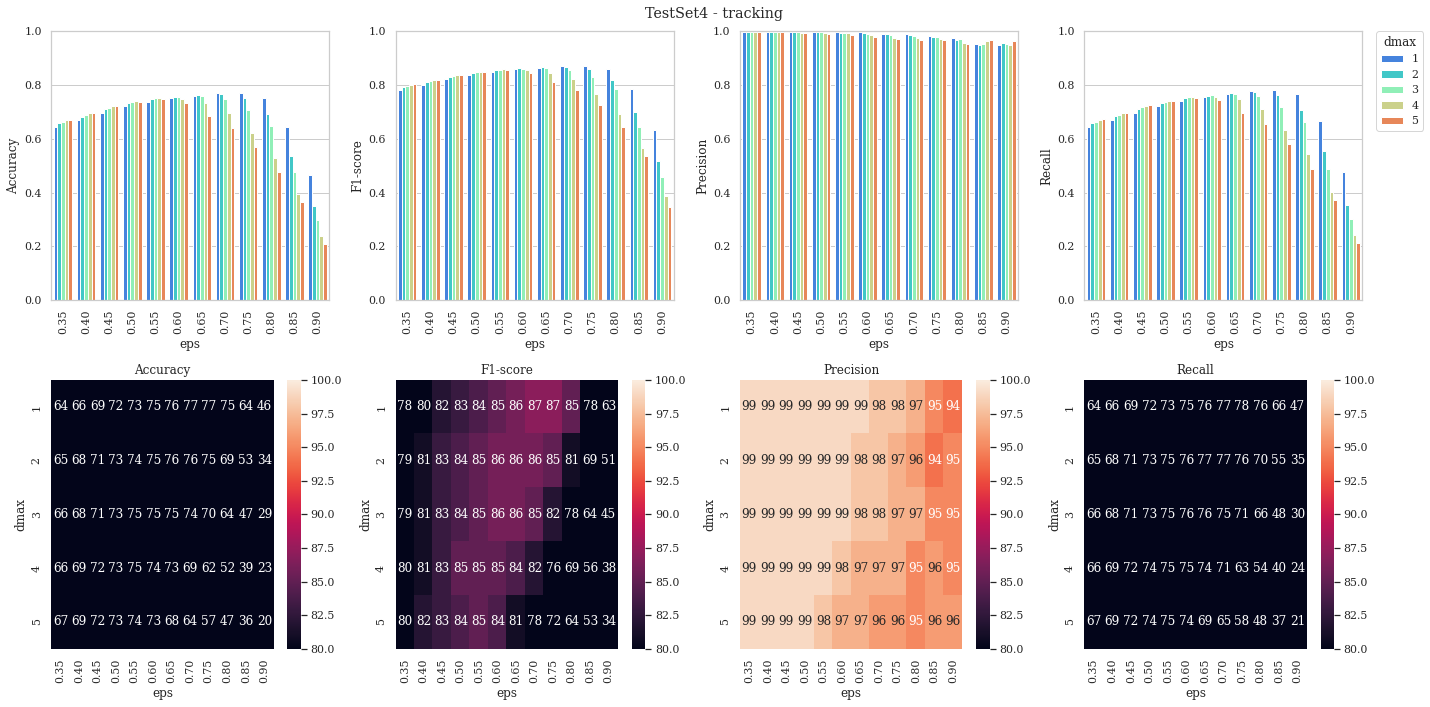

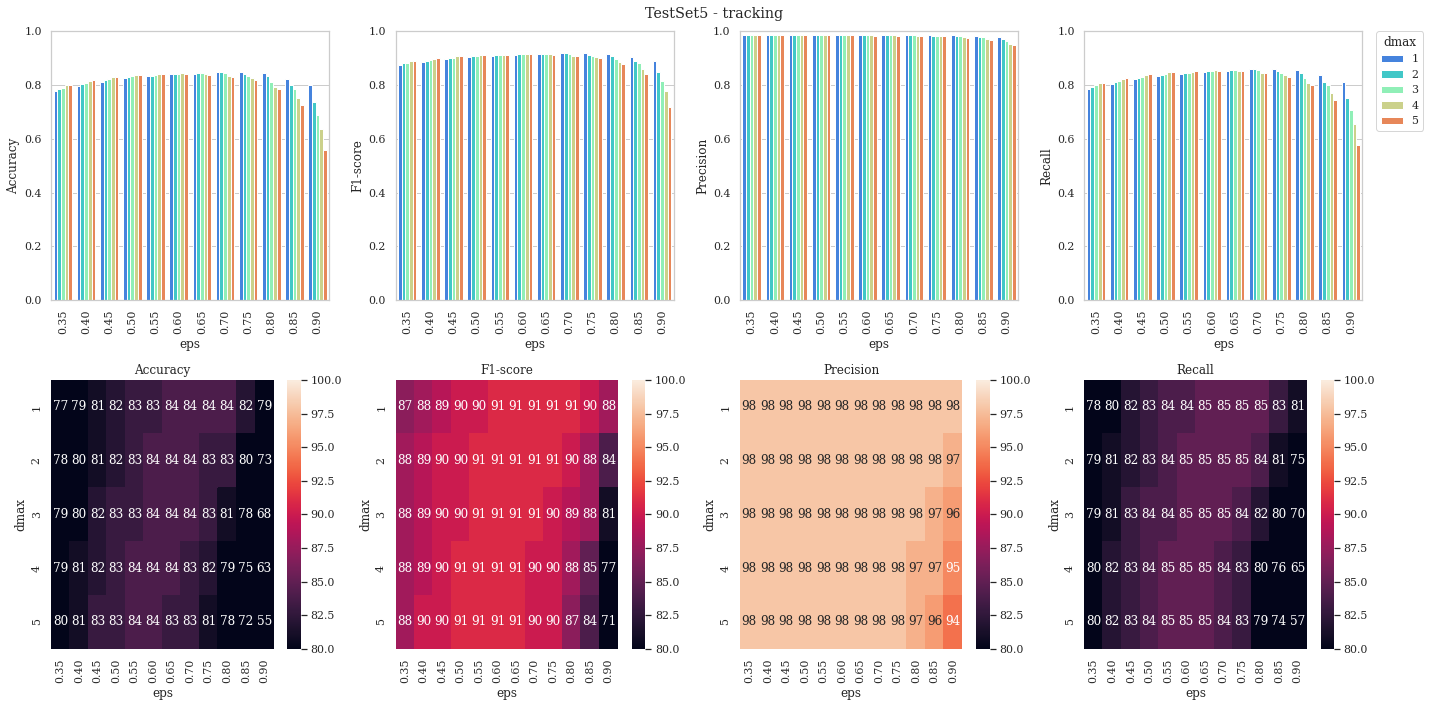

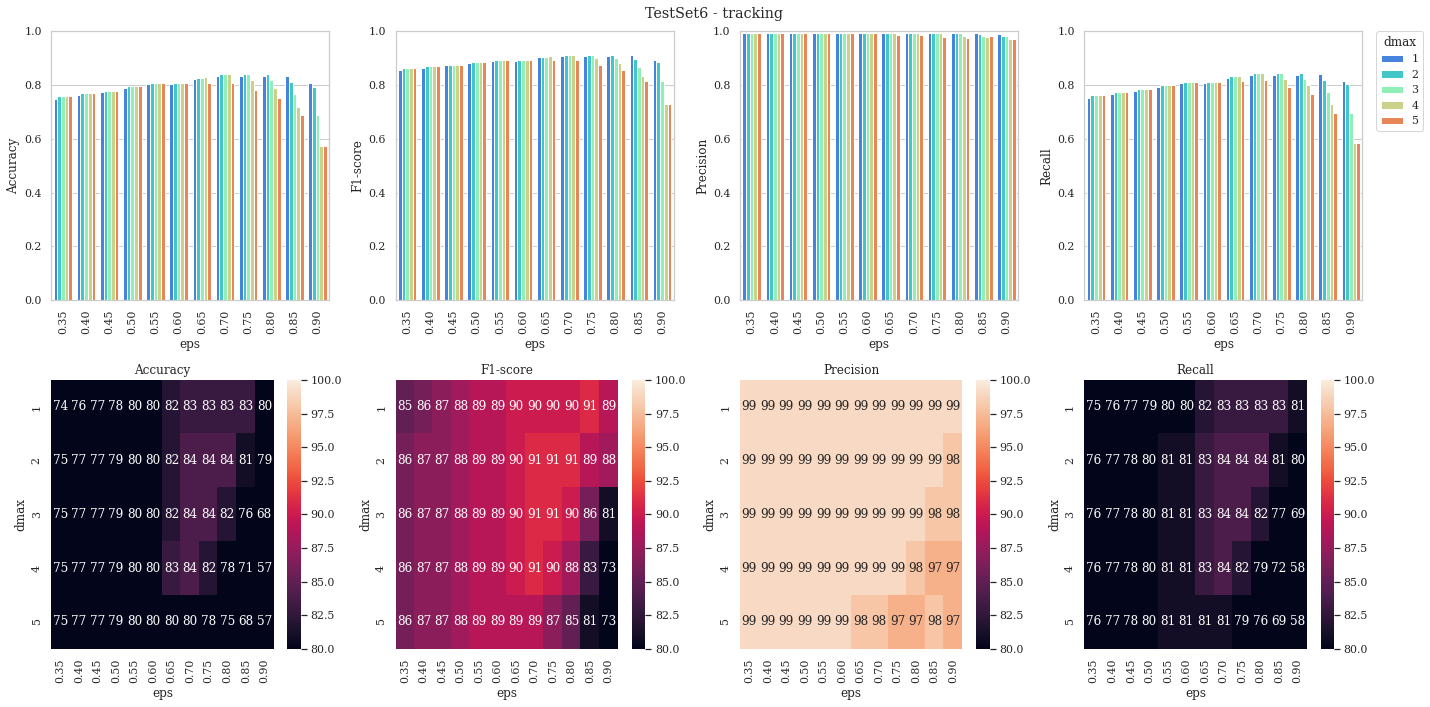

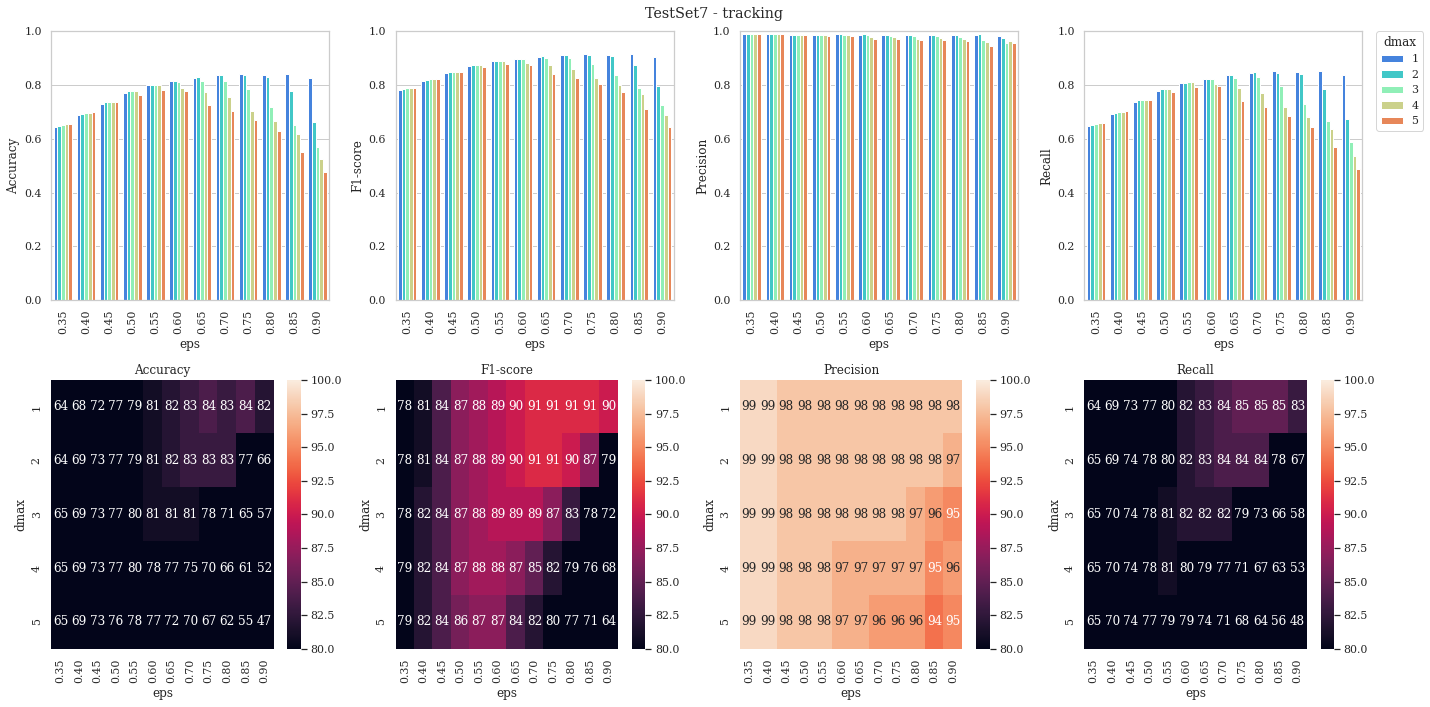

In [ ]:
#@markdown ## Plot performance

sns.set(font="Serif", font_scale=1, style="whitegrid")
for (testset_name, task), set_task_rows in tqdm(tracking_results.groupby(['test set', 'task'])):
  fig, axes = plt.subplots(2, 4, figsize=(20, 10))
  for (metric, rows), (ax0, ax1) in zip(set_task_rows.groupby('metric'), axes.T):
    rows = rows.rename({'value': metric}, axis=1)
    sns.barplot(data=rows.rename({'value': metric}, axis=1),
                hue='dmax', x='eps', y=metric, palette='rainbow', ax=ax0)
    ax0.set_xticklabels([f'{eps:0.2f}' for eps in epsilons], rotation=90)
    ax0.set_ylim(0, 1)
    if ax0 == axes[0,3]:
      ax0.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='dmax')
    else:
      ax0.legend([],[], frameon=False)

    # Show as pecentages
    rows = (100 * rows.pivot('dmax', columns=['eps'], values=metric)).astype(int)
    sns.heatmap(data=rows, annot=True, ax=ax1, vmin=80, vmax=100, fmt='d')
    ax1.set_xticklabels([f'{eps:0.2f}' for eps in epsilons], rotation=90)
    ax1.set_title(metric)
  plt.tight_layout(rect=(0, 0, 1, 0.97)) # allow some space for the main title
  fig.suptitle(f'{testset_name} - {task}')

#### Export

Save and download these results as a spreadsheets.

In [ ]:
#@markdown # Download results

tracking_results.pivot(
  index=['test set', 'dmax', 'eps'],
  columns=['task', 'metric'], values='value').to_excel('tracking-tuning-results.xlsx')

try:
  from google.colab.files import download
  download('tracking-tuning-results.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Exports for paper

In [ ]:
exports_for_paper = True #@param {"type": "boolean"}

sns.set(font="Serif", font_scale=1.5, style="whitegrid")

def crop(fn):
  im = imread(fn)
  is_white = (im[..., :3] == 255).min(2)
  y0, y1 = np.where(~is_white.min(1))[0][[0, -1]]
  x0, x1 = np.where(~is_white.min(0))[0][[0, -1]]
  imsave(fn, im[y0:y1+1, x0:x1+1])

if exports_for_paper:
  for testset_name, set_task_rows in tqdm(tracking_results[
    tracking_results['task'].isin(['tracking'])
    # & tracking_results['test set'].isin(['TestSet1', 'TestSet3', 'TestSet5'])
  ].groupby('test set')):
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    for (metric, rows), axis in zip(set_task_rows.groupby('metric'), axes.ravel()):
      rows = rows.rename({'value': metric}, axis=1)
      g = sns.barplot(data=rows, hue='dmax', x='eps', y=metric,
                      palette='rainbow', ax=axis)
      axis.set_ylim(int(rows[metric].min() * 5) / 5, 1)
      axis.set_xticks(np.arange(len(epsilons)))
      axis.set_xticklabels([f'{eps:0.2f}' for eps in epsilons], rotation=90)
      if axis == axes[0,1]:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                    title='$\Delta t_{max}$')
      else:
        axis.legend([],[], frameon=False)
    plt.tight_layout()
    
    fn = f'Tracking-calibration-curve-segmentation-{testset_name}.png'
    fig.savefig(fn)
    crop(fn)
    !zip -qq paper-results.zip '{fn}'
    !rm '{fn}'
    plt.close()
  !zip -qq paper-results.zip 'tracking-tuning-results.xlsx'

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.


### Acountability of False Positives and Negatives

Illustrates whether segentation or tracking causes the tracking errors. Ideally, one would compare tracking performance on the segmetation output and the ground truth segmentation, to empirically establish the cause. However, the YIT ground truths do not contain segmentations, but rather coordinates, and hence can't be used as input for tracking.

The `get_tracking_metrics` does not just report false negatives, positives and true positives, but also the cause of these false negatives and positives.

Note that false negatives and true positives partition the following set of ground truths in adjacent frames with the same label:

$S_1 = \{(a, b) \vert a, b \in \textrm{ground truth}, a\neq b,\;frame(a)=frame(b)+1,\; label(a) = label(b)\}$

Where $label$ is the tracking label assigned by the ground truth. The false negatives are those for which

 * Mask-RCNN segmentation didn't detect either $a$ or $b$ (segmentation column), or else
 * Tracking marked either or both $a$ or $b$ as an outlier (untracked column), or else
 * Tracking did not assign the same label to $a$ and $b$ (poor tracking column)

A similar set over partitions the false positives and true positives of detections in adjacent frames with the same tracking label:

$S_2 = \{(a, b) \vert a, b \in \textrm{detections},\;a\neq b,\;frame(a)=frame(b)+1,\;\hat{label}(a) = \hat{label}(b)\}$

Where $\hat{label}$ is the tracking label assigned by the algorithm. In this case the false positives can be classified 
 * Either or both $a$ and $b$ were not in the ground truth (segmentation column), or else
 * The ground truth did not assign the same label to $a$ and $b$ (poor tracking column).

Due to this partitioning, the false positives and negatives can be accounted to either segmention errors, tracking ourliers or a tracking mistake.



In [ ]:
#@markdown # Identify tracking errors

metrics = []
import time

for testset_name in tqdm(testset_names, desc='Overall evaluation progress'):
  image = yit.get_test_movie(data_path, testset_name)
  ground_truth = yit.get_ground_truth(data_path, testset_name)
    
  # Mask R-CNN results
  maskrcnn_detections, maskrcnn_masks = segmentation.get_segmentation(
      image, model_filename, seg_thresh=0.80, device='cuda:0')
  maskrcnn_detections['area'] = maskrcnn_masks.sum(1).sum(1)
  above_threshold = maskrcnn_detections['area'] >= 50
  maskrcnn_detections = maskrcnn_detections[above_threshold].copy()
  if 'cell' in ground_truth:
    maskrcnn_detections = tracking.track_cells(
        maskrcnn_detections, maskrcnn_masks, dmax=1, min_samples=3, eps=0.6, device='cuda:0')
  
  metrics.extend([
      {'test set': testset_name, 'task': task, 'model': model,
       'metric': metric, 'value': value}
      for task, get_metrics in {
          'tracking': evaluation.get_tracking_metrics,}.items()
      for model, detections, masks in [
        ('Mask R-CNN', maskrcnn_detections, maskrcnn_masks),
      ]
      for metric, value in get_metrics(
        ground_truth, detections, masks).items()
  ])

tracking_acounting_results = pd.DataFrame(metrics)

#### Results

In [ ]:
#@markdown # Display results

tracking_results_table = tracking_acounting_results.pivot('test set', 'metric', 'value')

fn = 'false negatives'
fp = 'false positives'
tracking_acounting = pd.DataFrame({
    (fn, '#'): 0,
    (fn, 'segmentation'): 100 * tracking_results_table['segmentation fn'] /
                                tracking_results_table['fn'],
    (fn, 'untracked'):    100 * tracking_results_table['untracked fn'] /
                               tracking_results_table['fn'],
    (fn, 'poor tracking'): 0,
    (fp, '#'): 0,
    (fp, 'segmentation'): 100 * tracking_results_table['segmentation fp'] /
                                tracking_results_table['fp'],
    (fp, 'poor tracking'): 0,
          
}).round(3)

tracking_acounting[(fn, 'poor tracking')] = 100 - tracking_acounting[fn].sum(1)
tracking_acounting[(fp, 'poor tracking')] = 100 - tracking_acounting[fp].sum(1)
tracking_acounting.loc[tracking_results_table['fp'] == 0, fp] = np.nan
tracking_acounting.loc[tracking_results_table['fn'] == 0, fn] = np.nan
tracking_acounting[(fn, '#')] = tracking_results_table['fn']
tracking_acounting[(fp, '#')] = tracking_results_table['fp']

tracking_acounting = tracking_acounting.style.bar(
    subset = [x for x in tracking_acounting.columns if x[1] != '#'],
    align='mid', color=['#d65f5f', '#5fba7d'], vmin=0, vmax=100).format(
        lambda x: f'{x:3.1f} %' if x==x else 'n/a',
        subset = [x for x in tracking_acounting.columns if x[1] != '#']
    ).format(
        lambda x: '{:3d}'.format(int(x)) if x==x else 'n/a',
        subset = [x for x in tracking_acounting.columns if x[1] == '#']
    ).set_properties(**{'text-align': 'center'})
tracking_acounting

#### Export

In [ ]:
#@markdown # Download results

tracking_acounting.to_excel('tracking-accounting-results.xlsx')

try:
  from google.colab.files import download
  download('tracking-accounting-results.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

#### Exports for paper

In [ ]:
exports_for_paper = True #@param {"type": "boolean"}

if exports_for_paper:
  tracking_acounting.to_excel('tracking-performance-accounting.xlsx')
  !zip -qq paper-results.zip 'tracking-performance-accounting.xlsx'
  !rm 'tracking-performance-accounting.xlsx'

In [ ]:
#@markdown # Running time estimation

metrics = []

devices = ['cuda:0', 'cpu'] # remove CPU if you're in a hurry

repeats = 4 # or lower the repeats if you want CPU results but are also in a
            # hurry


for _, testset_name, device in tqdm(list(product(range(repeats),
                                                 testset_names, devices))):
  image = yit.get_test_movie(data_path, testset_name)
  threshold = 0.8
  loading_time = -time.time()
  model = segmentation.get_model(model_filename, seg_thresh=threshold,
                                device=device)
  loading_time += time.time()

  segmentation_time = -time.time()
  maskrcnn_detections, maskrcnn_masks = segmentation.get_segmentation(image,
                                                                      model)
  segmentation_time += time.time()

  maskrcnn_detections['area'] = maskrcnn_masks.sum(1).sum(1)
  above_threshold = maskrcnn_detections['area'] >= 50
  maskrcnn_detections = maskrcnn_detections[above_threshold].copy()

  tracking_time = - time.time()
  if 'cell' in ground_truth:
    maskrcnn_detections = tracking.track_cells(
        maskrcnn_detections, maskrcnn_masks, dmax=1, min_samples=3, eps=0.6, device='cuda:0')
  tracking_time += time.time()
  
  metrics.extend([{
      'test set': testset_name, '# frames': image.shape[0],
      'height': image.shape[1], 'width': image.shape[2],
      '# detections': len(maskrcnn_detections), 'device': device,
      '# tracked cells': len(set(maskrcnn_detections['cell'].unique()) - {-1}),
      'task': task, 'running time': running_time,
    }
    for task, running_time in [
      ('loading segmentation model', loading_time),
      ('segmentation', segmentation_time),
      ('tracking', tracking_time),
    ]
  ])
  
running_time_results = pd.DataFrame(metrics)

### Results

In [ ]:
#@markdown # Display results

meta_columns = ['# frames', 'height', 'width', '# detections', '# tracked cells']
assert running_time_results.groupby(by=['test set', 'task'])[meta_columns].std().min().min() == 0, (
    "meta columns should not vary for the same test")

running_time_results['device'] = running_time_results['device'].replace('cuda:0', 'gpu')

running_time_mean = running_time_results.groupby(by=['test set', 'task', 'device'] + meta_columns).mean()[['running time']]
running_time_std = running_time_results.groupby(by=['test set', 'task', 'device'] + meta_columns).std()[['running time']]

for _ in range(len(meta_columns) + 3):
  running_time_mean.reset_index(level=0, inplace=True)
  running_time_std.reset_index(level=0, inplace=True)


running_time_mean = running_time_mean.pivot(['test set']+meta_columns, columns=['task', 'device'], values=['running time'])
running_time_std = running_time_std.pivot(['test set']+meta_columns, columns=['task', 'device'], values=['running time'])

running_time_mean.applymap('{:1.2f} ± '.format) + running_time_std.applymap('{:1.2f} s'.format)

running time  \
task                                                        loading segmentation model   
device                                                                             cpu   
test set # frames height width # detections # tracked cells                              
TestSet1 60       512    512   1151         26                           1.45 ± 0.20 s   
TestSet2 30       512    512   137          7                            0.88 ± 0.15 s   
TestSet3 20       512    512   2040         181                          1.23 ± 0.46 s   
TestSet4 20       512    512   3543         338                          1.19 ± 0.44 s   
TestSet5 20       512    512   2763         212                          1.24 ± 0.34 s   
TestSet6 10       512    512   388          43                           0.86 ± 0.11 s   
TestSet7 10       512    512   1390         156                          1.08 ± 0.34 s   

                                                                            \
task                                                                         
device                                                                 gpu   
test set # frames height width # detections # tracked cells                  
TestSet1 60       512    512   1151         26               1.70 ± 0.06 s   
TestSet2 30       512    512   137          7                1.24 ± 0.38 s   
TestSet3 20       512    512   2040         181              1.29 ± 0.47 s   
TestSet4 20       512    512   3543         338              1.64 ± 0.14 s   
TestSet5 20       512    512   2763         212              1.45 ± 0.35 s   
TestSet6 10       512    512   388          43               0.93 ± 0.05 s   
TestSet7 10       512    512   1390         156              1.48 ± 0.39 s   

                                                                              \
task                                                            segmentation   
device                                                                   cpu   
test set # frames height width # detections # tracked cells                    
TestSet1 60       512    512   1151         26               133.88 ± 6.57 s   
TestSet2 30       512    512   137          7                 58.18 ± 7.40 s   
TestSet3 20       512    512   2040         181               70.39 ± 6.57 s   
TestSet4 20       512    512   3543         338               95.68 ± 9.29 s   
TestSet5 20       512    512   2763         212               77.31 ± 8.92 s   
TestSet6 10       512    512   388          43                26.73 ± 2.59 s   
TestSet7 10       512    512   1390         156               40.72 ± 6.00 s   

                                                                            \
task                                                                         
device                                                                 gpu   
test set # frames height width # detections # tracked cells                  
TestSet1 60       512    512   1151         26               6.26 ± 0.15 s   
TestSet2 30       512    512   137          7                1.83 ± 0.13 s   
TestSet3 20       512    512   2040         181              4.27 ± 1.06 s   
TestSet4 20       512    512   3543         338              7.68 ± 0.67 s   
TestSet5 20       512    512   2763         212              5.63 ± 1.25 s   
TestSet6 10       512    512   388          43               0.88 ± 0.01 s   
TestSet7 10       512    512   1390         156              2.68 ± 0.63 s   

                                                                            \
task                                                              tracking   
device                                                                 cpu   
test set # frames height width # detections # tracked cells                  
TestSet1 60       512    512   1151         26               0.58 ± 0.18 s   
TestSet2 30       512    512   137          7                0.13 ± 0.05 s   
TestSet3 20     

### Export


In [ ]:
#@markdown # Download results

export = pd.merge(
    running_time_mean['running time'], running_time_std['running time'],
    left_index=True, right_index=True, suffixes=('  mean', '  stdev'),
)
export.columns =  pd.MultiIndex.from_tuples([(task, column[1], statistic) for column in export.columns
                                             for task, statistic in [column[0].split('  ')]])
export.columns.names = ['running time', 'device', 'statistic']
export = export[sorted(export.columns)]

export.to_excel('running-time-results.xlsx')

try:
  from google.colab.files import download
  download('running-time-results.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

### Exports for paper

In [ ]:
exports_for_paper = True #@param {"type": "boolean"}

if exports_for_paper:
  !zip -qq paper-results.zip 'running-time-results.xlsx'

## Download Exports for paper

In [ ]:
if exports_for_paper:
  try:
    from google.colab.files import download
    download('paper-results.zip')
  except ImportError:
    print('Not on Google Colab, won\'t start download')